In [33]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import time
# Sample dates and stock names
dates = pd.date_range("2023-01-01", periods=50, freq="D")
stocks = ["AAPL", "GOOG", "MSFT"]

# Create a MultiIndex from product of dates and stock names
index = pd.MultiIndex.from_product([dates, stocks], names=["date", "stock"])
np.random.seed(42)  # For reproducibility

# Generate some sample data
data = {
    "price": np.random.normal(0, 1, len(index)),
    "volume": np.random.uniform(-0.25, 0.25, len(index)),
}
data['return'] = data['price'] + np.random.uniform(-0.01, 0.01)
# Create the DataFrame
finance_df = pd.DataFrame(data, index=index)
print(finance_df)

# Display the DataFrame
def sharpe_loss(params, X, y, dates, alpha=0.001):
    weights = params[:-1]
    intercept = params[-1]
    # Compute predictions using linear regression

    predictions = X @ weights + intercept
    return np.sum(np.square(predictions - y)) + alpha * np.sum(np.square(params)) 

    # Convert predictions into a Series with the same index as dates
    pred_series = pd.Series(predictions, index=dates)
    # Normalize predictions within each day to use as weights
    norm_pred = pred_series.groupby(level=0).transform(lambda x: x / x.abs().sum())
    # Compute weighted (actual) returns and aggregate them by day
    weighted_returns = norm_pred * y
    daily_returns = pd.Series(weighted_returns, index=dates).groupby(level=0).sum()
    # Calculate Sharpe ratio: mean over std of daily returns
    sharpe_ratio = daily_returns.mean() / daily_returns.std()
    # time.sleep(1000)
    print("Sharpe ratio:", sharpe_ratio)
    return -sharpe_ratio + alpha * np.sum(np.square(params))  # Negative Sharpe ratio with regularization term

# Prepare input data from finance_df
X = finance_df[['price', 'volume']].values
# print(X)
y = finance_df['return'].values
dates = finance_df.index.get_level_values('date')
# print(dates)


# Initialize parameters: one weight per feature plus an intercept
np.random.seed()  # For reproducibility
initial_params = np.random.normal(0, 1, X.shape[1] + 1)
# initial_params = [1, 0, 0]
bounds = [(0.9, 1.1), (0, 0.0), (0, 0)]

# Optimize the parameters to maximize the Sharpe ratio (minimize negative Sharpe ratio)
result = minimize(sharpe_loss, initial_params, args=(X, y, dates), method='L-BFGS-B', bounds=bounds)

# Extract the optimized weights and intercept
optimized_weights = result.x[:-1]
optimized_intercept = result.x[-1]

print("Optimized weights:", optimized_weights)
print("Optimized intercept:", optimized_intercept)


                     price    volume    return
date       stock                              
2023-01-01 AAPL   0.496714  0.193543  0.494206
           GOOG  -0.138264  0.139938 -0.140772
           MSFT   0.647689  0.071016  0.645181
2023-01-02 AAPL   1.523030 -0.207930  1.520522
           GOOG  -0.234153 -0.169186 -0.236661
...                    ...       ...       ...
2023-02-18 GOOG   0.781823 -0.033074  0.779315
           MSFT  -1.236951 -0.050748 -1.239458
2023-02-19 AAPL  -1.320457  0.057925 -1.322964
           GOOG   0.521942  0.067547  0.519434
           MSFT   0.296985 -0.227348  0.294477

[150 rows x 3 columns]
Optimized weights: [1.00022477 0.        ]
Optimized intercept: 0.0


In [52]:
import pandas as pd
import numpy as np
np.random.seed(42)  # For reproducibility
from numpy.linalg import cholesky

n = 2000
dates = pd.date_range("2015-01-01", periods=n, freq="D")

stocks = ["GOOG", "AAPL", "MSFT", "AMZN", "TSLA"]

# Update the correlation matrix to include the new stocks
correlation_matrix = np.array([
    [1.0, 0.99, 0.0, 0.0, 0.0],
    [0.99, 1, 0.0, 0.0, 0.0],
    [0.0, 0.0, 1.0, 0.0, 0.0],
    [0.0, 0.0, 0.0, 1.0, -0.99],
    [0.0, 0.0, 0.0, -0.99, 1.0]
])

# Perform Cholesky decomposition
L = cholesky(correlation_matrix)

# Generate uncorrelated random variables
uncorrelated = np.random.normal(size=(n, len(stocks)))

# Adjust mean and standard deviation for each stock
means = [0, 1, -0.1, 0.5, -0.2]
stds = [1, 1, 1, 1, 1]
adjusted_uncorrelated = uncorrelated * stds + means

# Create correlated random variables
correlated = adjusted_uncorrelated @ L.T
# Repeat for each stock and date
price_data = correlated.flatten()



# Create a MultiIndex from product of dates and stock names
index = pd.MultiIndex.from_product([dates, stocks], names=["date", "stock"])


# Generate some sample data
data = {
    "price": price_data,
    "volume": np.random.uniform(-0.25, 0.25, len(index)),
}
# data['return'] = data['price'] + np.random.uniform(-0.01, 0.01)
data['return'] = np.random.normal(0, 1, len(index))
# Create the DataFrame
finance_df = pd.DataFrame(data, index=index)


# Filter the data for the given date range
filtered_data = finance_df.loc["2015-01-01":"2018-12-20", "price"].unstack(level="stock")

# Compute the correlation and covariance matrices for the filtered data
price_correlation_matrix = filtered_data.corr().loc[stocks, stocks]
price_cov_matrix = filtered_data.cov().loc[stocks, stocks]
print("Correlation matrix for the price of stocks between 2015-01-01 and 2015-01-20:")
print(price_correlation_matrix)

# Replace cholesky decomposition with eigenvalue decomposition for the correlation matrix
eigenvalues_corr, eigenvectors_corr = np.linalg.eigh(price_correlation_matrix)
eigenvalues_corr[eigenvalues_corr < 0] = 0  # Ensure non-negative eigenvalues
sqrt_eigenvalues_corr = np.sqrt(eigenvalues_corr)
transform_matrix_corr = np.round(eigenvectors_corr @ np.diag(sqrt_eigenvalues_corr) @ eigenvectors_corr.T, 3)

# Eigenvalue decomposition for the covariance matrix
eigenvalues_cov, eigenvectors_cov = np.linalg.eigh(price_cov_matrix)
eigenvalues_cov[eigenvalues_cov < 0] = 0
sqrt_eigenvalues_cov = np.sqrt(eigenvalues_cov)
transform_matrix_cov = eigenvectors_cov @ np.diag(sqrt_eigenvalues_cov) @ eigenvectors_cov.T

print("Eigen transform matrix for the price correlation matrix:\n", transform_matrix_corr)

# Transform the returns using the new eigen-based matrices
returns_matrix = finance_df['return'].unstack(level='stock')[stocks].values
transposed_returns = returns_matrix @ transform_matrix_corr.T
transposed_returns_cov = returns_matrix @ transform_matrix_cov.T

# Flatten the transposed returns and add them as new columns in finance_df
finance_df['transposed_return'] = transposed_returns.flatten(order='C')
finance_df['transposed_return_cov'] = transposed_returns_cov.flatten(order='C')
finance_df.head(20)


Correlation matrix for the price of stocks between 2015-01-01 and 2015-01-20:
stock      GOOG      AAPL      MSFT      AMZN      TSLA
stock                                                  
GOOG   1.000000  0.989373  0.017456  0.002237 -0.004044
AAPL   0.989373  1.000000  0.013245 -0.000002 -0.001935
MSFT   0.017456  0.013245  1.000000  0.002337 -0.003193
AMZN   0.002237 -0.000002  0.002337  1.000000 -0.990204
TSLA  -0.004044 -0.001935 -0.003193 -0.990204  1.000000
Eigen transform matrix for the price correlation matrix:
 [[ 0.757  0.654  0.008  0.001 -0.002]
 [ 0.654  0.757  0.004 -0.001 -0.001]
 [ 0.008  0.004  1.     0.001 -0.002]
 [ 0.001 -0.001  0.001  0.755 -0.656]
 [-0.002 -0.001 -0.002 -0.656  0.755]]


price    volume    return  transposed_return  \
date       stock                                                    
2015-01-01 GOOG   0.496714 -0.089372 -0.479459          -1.032462   
           AAPL   0.613310 -0.198490 -1.028068          -1.087831   
           MSFT   0.547689 -0.214096  0.502002           0.492883   
           AMZN   2.023030 -0.202862 -1.706863          -1.111928   
           TSLA  -2.064044  0.041435 -0.267839           0.918466   
2015-01-02 GOOG  -0.234137 -0.224169 -2.553631          -2.814402   
           AAPL   0.132047 -0.081537 -1.336402          -2.687025   
           MSFT   0.667435  0.126600 -0.877134          -0.903188   
           AMZN   0.030526 -0.102826  1.096724           0.374534   
           TSLA   0.018104  0.131654  0.688108          -0.191732   
2015-01-03 GOOG  -0.463418  0.122734 -0.553935           0.067388   
           AAPL  -0.383415 -0.127086  0.729370           0.194955   
           MSFT   0.141962  0.114411  0.887623           0.888717   
           AMZN  -1.413280  0.123888 -0.160665           0.786454   
           TSLA   1.127604 -0.051273 -1.384378          -0.941206   
2015-01-04 GOOG  -0.562288 -0.144790 -0.207912          -0.231463   
           AAPL  -0.558475  0.010635 -0.097892          -0.215656   
           MSFT   0.214247  0.210699 -1.232454          -1.234702   
           AMZN  -0.408024  0.069808  0.367047           0.092221   
           TSLA   0.176500 -0.163539  0.279812          -0.026546   

                  transposed_return_cov  
date       stock                         
2015-01-01 GOOG               -1.036998  
           AAPL               -1.088825  
           MSFT                0.497177  
           AMZN               -1.099977  
           TSLA                0.909943  
2015-01-02 GOOG               -2.830931  
           AAPL               -2.692138  
           MSFT               -0.912807  
           AMZN                0.369550  
           TSLA               -0.189967  
2015-01-03 GOOG                0.066161  
           AAPL                0.193720  
           MSFT                0.896530  
           AMZN                0.779694  
           TSLA               -0.934332  
2015-01-04 GOOG               -0.233161  
           AAPL               -0.216523  
           MSFT               -1.246254  
           AMZN                0.091137  
           TSLA               -0.026518

In [45]:
import pandas as pd
import numpy as np
np.random.seed(42)  # For reproducibility
from numpy.linalg import cholesky

n = 2000
dates = pd.date_range("2015-01-01", periods=n, freq="D")

stocks = ["GOOG", "AAPL", "MSFT", "AMZN", "TSLA"]

# Update the correlation matrix to include the new stocks
correlation_matrix = np.array([
    [1.0, 0.5, 0.0, 0.0, 0.0],
    [0.5, 1.0, 0.0, 0.0, 0.0],
    [0.0, 0.0, 1.0, 0.0, 0.0],
    [0.0, 0.0, 0.0, 1.0, -0.8],
    [0.0, 0.0, 0.0, -0.8, 1.0]
])

# Perform Cholesky decomposition
L = cholesky(correlation_matrix)

# Generate uncorrelated random variables
uncorrelated = np.random.normal(size=(n, len(stocks)))

# Adjust mean and standard deviation for each stock
means = [0, 1, -0.1, 0.5, -0.2]
stds = [1, 1, 1, 1, 1]
adjusted_uncorrelated = uncorrelated * stds + means

# Create correlated random variables
correlated = adjusted_uncorrelated @ L.T
# Repeat for each stock and date
price_data = correlated.flatten()



# Create a MultiIndex from product of dates and stock names
index = pd.MultiIndex.from_product([dates, stocks], names=["date", "stock"])


# Generate some sample data
data = {
    "price": price_data,
    "volume": np.random.uniform(-0.25, 0.25, len(index)),
}
# data['return'] = data['price'] + np.random.uniform(-0.01, 0.01)
data['return'] = np.random.normal(0, 1, len(index))
# Create the DataFrame
finance_df = pd.DataFrame(data, index=index)

# Sort the data by date and stock
finance_df.sort_index(inplace=True)
stocks = sorted(stocks)
print(stocks)
# Filter the data for the given date range
filtered_data = finance_df.loc["2015-01-01":"2018-12-20", "price"].unstack(level="stock")

# Compute the correlation matrix for the filtered data
price_correlation_matrix = filtered_data.corr().loc[stocks, stocks]
price_cov_matrix = filtered_data.cov().loc[stocks, stocks]
print("Correlation matrix for the price of stocks between 2015-01-01 and 2015-01-20:")
print(price_correlation_matrix)

# Replace cholesky decomposition with eigenvalue decomposition for correlation matrix
eigenvalues_corr, eigenvectors_corr = np.linalg.eigh(price_correlation_matrix)
eigenvalues_corr[eigenvalues_corr < 0] = 0  # Ensure non-negative eigenvalues
sqrt_eigenvalues_corr = np.sqrt(eigenvalues_corr)
transform_matrix_corr = np.round(eigenvectors_corr @ np.diag(sqrt_eigenvalues_corr) @ eigenvectors_corr.T, 3)

# Eigenvalue decomposition for covariance matrix
eigenvalues_cov, eigenvectors_cov = np.linalg.eigh(price_cov_matrix)
eigenvalues_cov[eigenvalues_cov < 0] = 0
sqrt_eigenvalues_cov = np.sqrt(eigenvalues_cov)
transform_matrix_cov = eigenvectors_cov @ np.diag(sqrt_eigenvalues_cov) @ eigenvectors_cov.T

print("Eigen transform matrix for the price correlation matrix:\n", transform_matrix_corr)

# Transform the returns using the new eigen-based matrices
returns_matrix = finance_df['return'].unstack(level='stock').values
transposed_returns = returns_matrix @ transform_matrix_corr.T
transposed_returns_cov = returns_matrix @ transform_matrix_cov.T

# Flatten the transposed returns and add it as a new column in finance_df
finance_df['transposed_return'] = transposed_returns.flatten(order='C')
finance_df['transposed_return_cov'] = transposed_returns_cov.flatten(order='C')
finance_df.head(20)


['AAPL', 'AMZN', 'GOOG', 'MSFT', 'TSLA']
Correlation matrix for the price of stocks between 2015-01-01 and 2015-01-20:
stock      AAPL      AMZN      GOOG      MSFT      TSLA
stock                                                  
AAPL   1.000000 -0.012413  0.468123 -0.016292  0.003099
AMZN  -0.012413  1.000000  0.002237  0.002337 -0.805862
GOOG   0.468123  0.002237  1.000000  0.017456 -0.009558
MSFT  -0.016292  0.002337  0.017456  1.000000 -0.005611
TSLA   0.003099 -0.805862 -0.009558 -0.005611  1.000000
Eigen transform matrix for the price correlation matrix:
 [[ 0.97  -0.007  0.241 -0.009  0.001]
 [-0.007  0.892  0.001  0.001 -0.452]
 [ 0.241  0.001  0.97   0.01  -0.005]
 [-0.009  0.001  0.01   1.    -0.003]
 [ 0.001 -0.452 -0.005 -0.003  0.892]]


price    volume    return  transposed_return  \
date       stock                                                    
2015-01-01 AAPL   0.994642 -0.198490 -1.028068          -1.105613   
           AMZN   2.023030 -0.202862 -1.706863          -1.394239   
           GOOG   0.496714 -0.089372 -0.479459          -0.708188   
           MSFT   0.547689 -0.214096  0.502002           0.505557   
           TSLA  -1.878916  0.041435 -0.267839           0.532452   
2015-01-02 AAPL   2.116595 -0.081537 -1.336402          -1.910830   
           AMZN   0.030526 -0.102826  1.096724           0.673177   
           GOOG  -0.234137 -0.224169 -2.553631          -2.810210   
           MSFT   0.667435  0.126600 -0.877134          -0.891610   
           TSLA   0.181116  0.131654  0.688108           0.132136   
2015-01-03 AAPL   0.230983 -0.127086  0.729370           0.565742   
           AMZN  -1.413280  0.123888 -0.160665           0.477654   
           GOOG  -0.463418  0.122734 -0.553935          -0.345901   
           MSFT   0.141962  0.114411  0.887623           0.879512   
           TSLA  -0.024327 -0.051273 -1.384378          -1.161409   
2015-01-04 AAPL  -0.292256  0.010635 -0.097892          -0.136260   
           AMZN  -0.408024  0.069808  0.367047           0.200176   
           GOOG  -0.562288 -0.144790 -0.207912          -0.238624   
           MSFT   0.214247  0.210699 -1.232454          -1.234125   
           TSLA  -0.640963 -0.163539  0.279812           0.088326   

                  transposed_return_cov  
date       stock                         
2015-01-01 AAPL               -1.119960  
           AMZN               -1.380263  
           GOOG               -0.713122  
           MSFT                0.511516  
           TSLA                0.527527  
2015-01-02 AAPL               -1.932131  
           AMZN                0.665961  
           GOOG               -2.828534  
           MSFT               -0.899580  
           TSLA                0.134055  
2015-01-03 AAPL                0.572965  
           AMZN                0.474042  
           GOOG               -0.347289  
           MSFT                0.887071  
           TSLA               -1.157423  
2015-01-04 AAPL               -0.137134  
           AMZN                0.198425  
           GOOG               -0.240242  
           MSFT               -1.245621  
           TSLA                0.088529

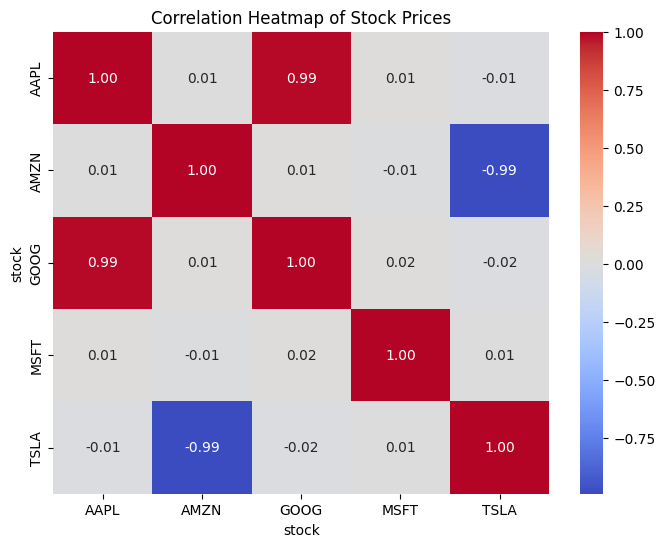

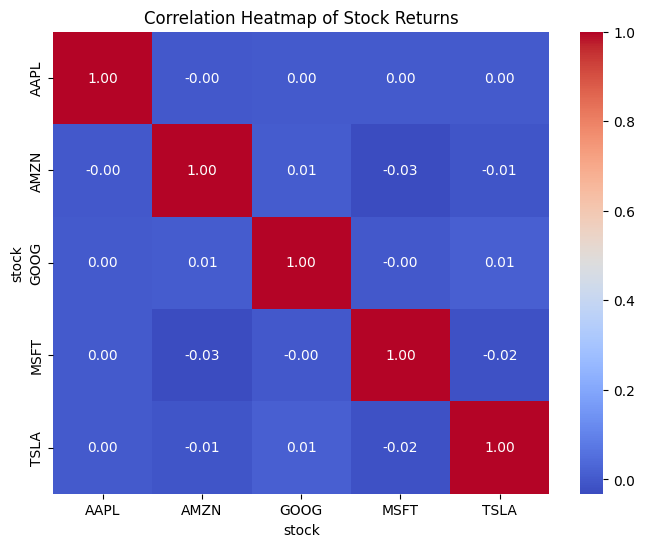

In [36]:
import seaborn as sns



import matplotlib.pyplot as plt

# Pivot the finance_df to create a matrix of prices for each stock over time
price_matrix = finance_df['price'].unstack(level='stock')

# Compute the correlation matrix
correlation_matrix = price_matrix.corr()
# Reorder the correlation matrix to match the order in the dataframe
correlation_matrix = correlation_matrix.loc[stocks, stocks]
# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap of Stock Prices")
plt.show()

# Pivot the finance_df to create a matrix of prices for each stock over time
price_matrix = finance_df['return'].unstack(level='stock')

# Compute the correlation matrix
correlation_matrix = price_matrix.corr()
# Reorder the correlation matrix to match the order in the dataframe
correlation_matrix = correlation_matrix.loc[stocks, stocks]
# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap of Stock Returns")
plt.show()

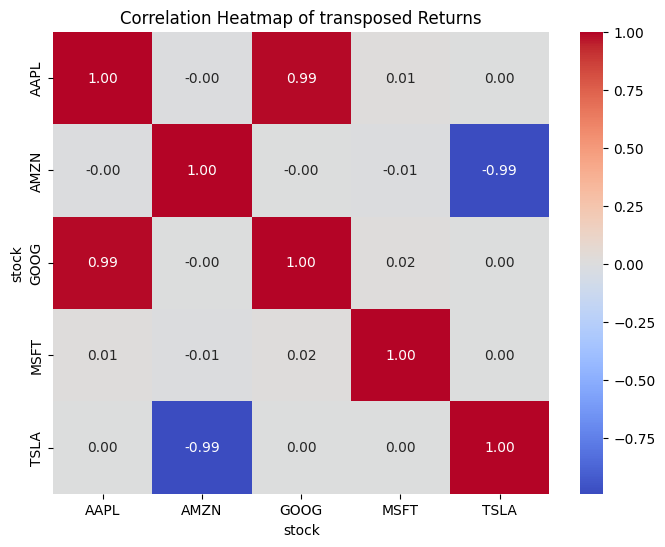

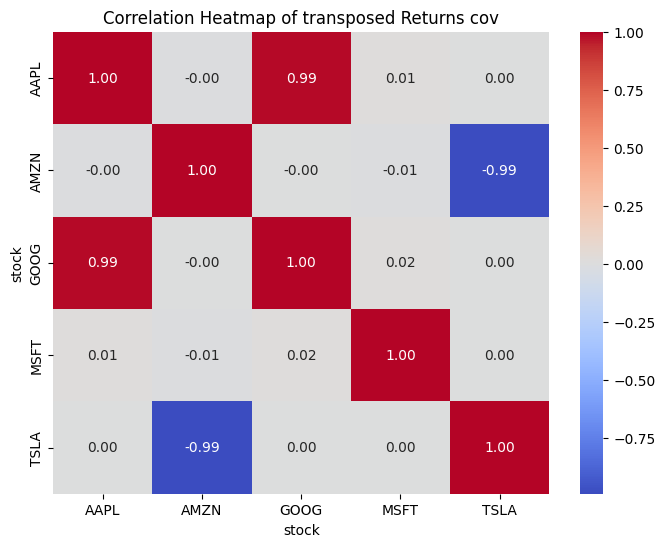

In [37]:

# Pivot the finance_df to create a matrix of prices for each stock over time
price_matrix = finance_df['transposed_return'].unstack(level='stock')

# Compute the correlation matrix
correlation_matrix = price_matrix.corr()
# Reorder the correlation matrix to match the order in the dataframe
correlation_matrix = correlation_matrix.loc[stocks, stocks]
# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap of transposed Returns")
plt.show()


# Pivot the finance_df to create a matrix of prices for each stock over time
price_matrix = finance_df['transposed_return_cov'].unstack(level='stock')

# Compute the correlation matrix
correlation_matrix = price_matrix.corr()
# Reorder the correlation matrix to match the order in the dataframe
correlation_matrix = correlation_matrix.loc[stocks, stocks]
# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap of transposed Returns cov")
plt.show()

In [ ]:
import numpy as np
import pandas as pd

# Example correlation matrix
C = np.array([
    [1.0, 0.9],
    [0.9, 1.0]
])

# Eigenvalue decomposition
eigenvalues, eigenvectors = np.linalg.eigh(C)
# Ensure non-negative eigenvalues for sqrt (adjust if needed)
eigenvalues[eigenvalues < 0] = 0
sqrt_eigenvalues = np.sqrt(eigenvalues)
# Construct the transformation matrix
transform_matrix = eigenvectors @ np.diag(sqrt_eigenvalues) @ eigenvectors.T
print("Transform matrix:")
print(transform_matrix)
# Generate uncorrelated random variables
n_samples = 100
uncorrelated = np.random.normal(size=(n_samples, C.shape[0]))

# Generate correlated random variables
correlated = uncorrelated @ transform_matrix.T
print(correlated)
# Convert the correlated array to a pandas DataFrame
correlated_df = pd.DataFrame(correlated, columns=["Var1", "Var2"])

# Compute and print the correlation matrix
print(correlated_df.corr())

Transform matrix:
[[0.84731632 0.53108855]
 [0.53108855 0.84731632]]
[[ 7.63321725e-02 -1.56325209e-01]
 [ 4.90222000e-01 -7.21620487e-02]
 [-6.68564794e-01 -1.16191802e-03]
 [-5.12248602e-01 -4.83901550e-01]
 [-7.82324940e-01 -7.33586892e-01]
 [ 2.07174719e+00  2.15379733e+00]
 [ 2.09986528e+00  1.87696960e+00]
 [-3.65591237e-01 -9.65967628e-01]
 [ 9.86534883e-01  1.72786105e+00]
 [ 4.35035527e-01  1.05160569e+00]
 [-1.37569802e+00 -2.24000486e+00]
 [ 1.21518725e+00  1.41307282e+00]
 [ 6.13344192e-01  1.01876304e+00]
 [-2.14903480e+00 -2.05977532e+00]
 [ 4.26975043e-01  5.13068185e-01]
 [ 1.48877689e+00  1.26183464e+00]
 [-8.98235317e-01 -4.53405715e-01]
 [-4.86378057e-01 -1.26902959e+00]
 [-2.15195399e-01 -3.07517803e-01]
 [-2.89837343e-01  7.49219381e-02]
 [-7.52743983e-01 -2.57353886e-01]
 [ 1.04964025e+00  1.21542968e+00]
 [-1.75130414e+00 -1.87204463e+00]
 [ 8.42842026e-02 -9.44397749e-02]
 [ 2.70296623e+00  1.93005757e+00]
 [-4.25055816e-02 -1.15550928e-01]
 [-7.32612642e-01 -1.

In [5]:
# Example of time-aware cross validation using TimeSeriesSplit
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Create a sample time series dataset
dates = pd.date_range(start='2023-01-01', periods=100, freq='D')
data = pd.DataFrame({
    'feature': np.random.randn(100),
    'target': np.random.randn(100)
}, index=dates)
print(data)
X = data[['feature']].values
y = data['target'].values

# Set up a time series split
tscv = TimeSeriesSplit(n_splits=5)
print(tscv)
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Train the model on past data and test on future data
    model = LinearRegression()
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    
    mse = mean_squared_error(y_test, predictions)
    print("Train period:", data.index[train_index[0]], "to", data.index[train_index[-1]])
    print("Test period:", data.index[test_index[0]], "to", data.index[test_index[-1]])
    print("MSE:", mse, "\n")

             feature    target
2023-01-01  0.710144 -0.276161
2023-01-02 -1.371719  0.434860
2023-01-03 -0.986100 -2.229131
2023-01-04 -1.280236 -0.374691
2023-01-05  0.338926  1.290563
...              ...       ...
2023-04-06 -0.035142  0.804292
2023-04-07 -0.341384  1.148107
2023-04-08  2.317388 -0.250492
2023-04-09  0.299720  0.891553
2023-04-10 -0.641820  0.399610

[100 rows x 2 columns]
TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None)
Train period: 2023-01-01 00:00:00 to 2023-01-20 00:00:00
Test period: 2023-01-21 00:00:00 to 2023-02-05 00:00:00
MSE: 0.9873041165466545 

Train period: 2023-01-01 00:00:00 to 2023-02-05 00:00:00
Test period: 2023-02-06 00:00:00 to 2023-02-21 00:00:00
MSE: 0.9696121707932417 

Train period: 2023-01-01 00:00:00 to 2023-02-21 00:00:00
Test period: 2023-02-22 00:00:00 to 2023-03-09 00:00:00
MSE: 0.875072401273875 

Train period: 2023-01-01 00:00:00 to 2023-03-09 00:00:00
Test period: 2023-03-10 00:00:00 to 2023-03-25 00:00:00
MSE

In [18]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize

# Sample asset names
assets = ['Asset1', 'Asset2', 'Asset3']

# Define expected returns for each asset (annualized, for example)
expected_returns = np.array([0.08, 0.12, 0.10])

# Create a sample covariance matrix (annualized)
cov_matrix = np.array([
    [0.005, -0.010, 0.004],
    [-0.010, 0.040, -0.002],
    [0.004, -0.002, 0.023]
])

# Define the portfolio variance objective function
def portfolio_variance(weights, cov):
    return weights.T @ cov @ weights

# Constraint: the sum of weights must be 1 (fully invested portfolio)
constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})

# Bounds for weights (e.g. no short selling: weights between 0 and 1)
bounds = tuple((-1, 1) for _ in assets)

# Starting guess for weights
initial_guess = np.array([1/len(assets)] * len(assets))
print(initial_guess)
# Run the optimization to minimize variance
result = minimize(portfolio_variance, initial_guess, args=(cov_matrix,),
                  constraints=constraints, bounds=bounds, method='SLSQP')

# Extract optimal weights
optimal_weights = result.x
print("Optimal weights for the minimum variance portfolio:")
for asset, weight in zip(assets, optimal_weights):
    print(f"{asset}: {weight:.4f}")


[0.33333333 0.33333333 0.33333333]
Optimal weights for the minimum variance portfolio:
Asset1: 0.8194
Asset2: 0.2389
Asset3: -0.0583


In [16]:
a = np.array([1, 2, 3])
b = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
print(a.T @ b @ a.T)

14


In [14]:
import numpy as np

# Original 1D array
a_col = np.array([1, 2, 3])

# Reshape into a column vector (3x1)
# a_col = a.reshape(-1, 1)

# Now a_col.T results in a row vector (1x3)
print("a_col shape:", a_col.shape)
print("a_col.T shape:", a_col.T.shape)

a_col shape: (3,)
a_col.T shape: (3,)


In [22]:
import numpy as np

# Define a sample covariance matrix (e.g., for three assets)
Sigma = np.array([
    [0.005, -0.010, 0.004],
    [-0.010, 0.040, -0.002],
    [0.004, -0.002, 0.023]
])

# Create a vector of ones
ones = np.ones(Sigma.shape[0])

# Compute the inverse of Sigma
Sigma_inv = np.linalg.inv(Sigma)

# Compute the denominator: 1^T * Sigma_inv * 1
denom = ones.T @ Sigma_inv @ ones

# Closed-form solution for the minimum variance portfolio weights
w_star = (Sigma_inv @ ones) / denom

print("Minimum variance portfolio weights:")
print(w_star)

eigenvalues_cov, eigenvectors_cov = np.linalg.eigh(Sigma)
eigenvalues_cov[eigenvalues_cov < 0] = 0
sqrt_eigenvalues_cov = np.sqrt(eigenvalues_cov)
transform_matrix_cov = eigenvectors_cov @ np.diag(sqrt_eigenvalues_cov) @ eigenvectors_cov.T
print("Transform matrix for covariance matrix:")
print(transform_matrix_cov / np.linalg.norm(transform_matrix_cov, axis=1)[:, None])


Minimum variance portfolio weights:
[ 0.81870386  0.23872026 -0.05742412]
Transform matrix for covariance matrix:
[[ 0.78638174 -0.55817288  0.26466356]
 [-0.19734391  0.98016532 -0.0182021 ]
 [ 0.12340002 -0.02400422  0.99206665]]


In [122]:
import pandas as pd
import numpy as np
np.random.seed(42)  # For reproducibility
from numpy.linalg import cholesky

n = 2000
dates = pd.date_range("2015-01-01", periods=n, freq="D")

stocks = ["GOOG", "AAPL", "MSFT", "AMZN", "TSLA"]

# Update the correlation matrix to include the new stocks
correlation_matrix = np.array([
    [1.0, 0.0, 0.0, 0.0, 0.0],
    [0.0, 1.0, 0.0, 0.0, 0.0],
    [0.0, 0.0, 1.0, 0.0, 0.0],
    [0.0, 0.0, 0.0, 1.0, -0.0],
    [0.0, 0.0, 0.0, -0.0, 1.0]
])

# Perform Cholesky decomposition
L = cholesky(correlation_matrix)

# Generate uncorrelated random variables
uncorrelated = np.random.normal(size=(n, len(stocks)))

# Adjust mean and standard deviation for each stock
means = [0, 0, 0, 0, 0]
stds = [1, 1, 1, 1, 1]
adjusted_uncorrelated = uncorrelated * stds + means

# Create correlated random variables
correlated = adjusted_uncorrelated @ L.T
# Repeat for each stock and date
price_data = correlated.flatten()



# Create a MultiIndex from product of dates and stock names
index = pd.MultiIndex.from_product([dates, stocks], names=["date", "stock"])


# Generate some sample data
data = {
    "price": price_data,
    "volume": np.random.uniform(-0.25, 0.25, len(index)),
}
# data['return'] = data['price'] + np.random.uniform(-0.01, 0.01)
data['return'] = np.random.normal(0, 1, len(index)) + data['price']
# Create the DataFrame
finance_df = pd.DataFrame(data, index=index)

# Sort the data by date and stock
# finance_df.sort_index(inplace=True)
# stocks = sorted(stocks)

print(stocks)
finance_df.head(20)


['GOOG', 'AAPL', 'MSFT', 'AMZN', 'TSLA']


price    volume    return
date       stock                              
2015-01-01 GOOG   0.496714 -0.089372  0.017255
           AAPL  -0.138264 -0.198490 -1.166332
           MSFT   0.647689 -0.214096  1.149690
           AMZN   1.523030 -0.202862 -0.183833
           TSLA  -0.234153  0.041435 -0.501993
2015-01-02 GOOG  -0.234137 -0.224169 -2.787768
           AAPL   1.579213 -0.081537  0.242810
           MSFT   0.767435  0.126600 -0.109699
           AMZN  -0.469474 -0.102826  0.627250
           TSLA   0.542560  0.131654  1.230668
2015-01-03 GOOG  -0.463418  0.122734 -1.017352
           AAPL  -0.465730 -0.127086  0.263640
           MSFT   0.241962  0.114411  1.129585
           AMZN  -1.913280  0.123888 -2.073945
           TSLA  -1.724918 -0.051273 -3.109296
2015-01-04 GOOG  -0.562288 -0.144790 -0.770200
           AAPL  -1.012831  0.010635 -1.110724
           MSFT   0.314247  0.210699 -0.918207
           AMZN  -0.908024  0.069808 -0.540977
           TSLA  -1.412304 -0.163539 -1.132492

In [123]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize

# Pivot the returns into a daily DataFrame with stocks as columns
returns_df = finance_df['return'].unstack(level='stock')

def compute_weights(window):
    # Compute expected returns and covariance using the trailing window
    exp_ret = window.mean()
    cov_mat = window.cov()
    # Use pseudo-inverse for stability
    inv_cov = np.linalg.pinv(cov_mat)
    raw_weights = inv_cov @ exp_ret.values
    if raw_weights.sum() == 0:
        return np.repeat(np.nan, len(exp_ret))
    demo = np.sum([abs(i) for i in raw_weights])
    return raw_weights / demo

roll_window = 500
weights_df = pd.DataFrame(index=returns_df.index, columns=returns_df.columns)

for i in range(roll_window - 1, len(returns_df)):
    window = returns_df.iloc[i - roll_window + 1 : i + 1]
    weights_df.iloc[i] = compute_weights(window)
print(weights_df)
# Convert weights to long format and merge them with the original finance_df
weights_df_long = weights_df.reset_index().melt(id_vars='date', var_name='stock', value_name='close_form')
finance_df = finance_df.reset_index().merge(weights_df_long, on=['date','stock'], how='left').set_index(['date','stock'])
print(finance_df.tail(50))

# Define the objective function for optimization
def objective_function(weights, cov_matrix, exp_returns):
    # Negative Sharpe ratio (to maximize Sharpe ratio, we minimize its negative)
    portfolio_return = np.dot(weights, exp_returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return -portfolio_return / portfolio_volatility

# Constraints: weights sum to 1
constraints = ({'type': 'eq', 'fun': lambda w: np.sum(np.abs(w)) - 1})

# Bounds for weights (e.g., no short selling: weights between 0 and 1)
bounds = tuple((-1, 1) for _ in returns_df.columns)

# DataFrame to store optimized weights
optimized_weights_df = pd.DataFrame(index=returns_df.index, columns=returns_df.columns)

# Loop through the rolling window to compute optimized weights
for i in range(roll_window - 1, len(returns_df)):
    window = returns_df.iloc[i - roll_window + 1 : i + 1]
    exp_ret = window.mean()
    cov_mat = window.cov()
    
    # Initial guess for weights (equal allocation)
    initial_guess = np.array([1 / len(exp_ret)] * len(exp_ret))
    
    # Optimize weights
    result = minimize(objective_function, initial_guess, args=(cov_mat, exp_ret.values),
                      method='SLSQP', bounds=bounds, constraints=constraints)
    
    # Store the optimized weights
    if result.success:
        optimized_weights_df.iloc[i] = result.x
    else:
        optimized_weights_df.iloc[i] = np.nan

# Convert optimized weights to long format and merge with finance_df
optimized_weights_long = optimized_weights_df.reset_index().melt(id_vars='date', var_name='stock', value_name='scipy')
finance_df = finance_df.reset_index().merge(optimized_weights_long, on=['date', 'stock'], how='left').set_index(['date', 'stock'])
print(finance_df.tail(50))

stock           AAPL      AMZN      GOOG      MSFT      TSLA
date                                                        
2015-01-01       NaN       NaN       NaN       NaN       NaN
2015-01-02       NaN       NaN       NaN       NaN       NaN
2015-01-03       NaN       NaN       NaN       NaN       NaN
2015-01-04       NaN       NaN       NaN       NaN       NaN
2015-01-05       NaN       NaN       NaN       NaN       NaN
...              ...       ...       ...       ...       ...
2020-06-18  0.487622 -0.268193  0.036256  0.162398 -0.045531
2020-06-19   0.47703 -0.280103  0.037428  0.164985 -0.040454
2020-06-20  0.482868 -0.281731   0.03154  0.143379 -0.060482
2020-06-21  0.486218 -0.276704  0.039908  0.150148 -0.047022
2020-06-22   0.51033 -0.273535  0.053464  0.139658 -0.023013

[2000 rows x 5 columns]
                     price    volume    return close_form
date       stock                                         
2020-06-13 GOOG   0.867805  0.083228  0.102834   0.044237
        

In [43]:
import numpy as np

# Sample expected returns (annualized)
mu = np.array([0.08, 0.12, 0.10])

# Sample covariance matrix (annualized risk estimates)
Sigma = np.array([
    [0.005, -0.010, 0.004],
    [-0.010, 0.040, -0.002],
    [0.004, -0.002, 0.023]
])

# Define the risk-free rate (annualized)
r_f = 0.03

# Calculate excess returns
excess_returns = mu - r_f

# Compute the inverse of covariance matrix
Sigma_inv = np.linalg.inv(Sigma)

# Tangency portfolio weights (closed-form solution)
# w* = Sigma_inv * (mu - r_f * 1) / (1.T * Sigma_inv * (mu - r_f * 1))
numerator = Sigma_inv @ excess_returns
denom = np.ones(len(mu)).T @ Sigma_inv @ excess_returns
tangency_weights = numerator / denom

# Compute the portfolio's Sharpe ratio
sharpe_ratio = np.sqrt(excess_returns.T @ Sigma_inv @ excess_returns)

print("Tangency Portfolio Weights:", tangency_weights)
print("Maximum Sharpe Ratio:", sharpe_ratio)

Tangency Portfolio Weights: [ 0.7863464   0.25158028 -0.03792668]
Maximum Sharpe Ratio: 1.5315025301970613


Actual skewness: 0.15897184741923734


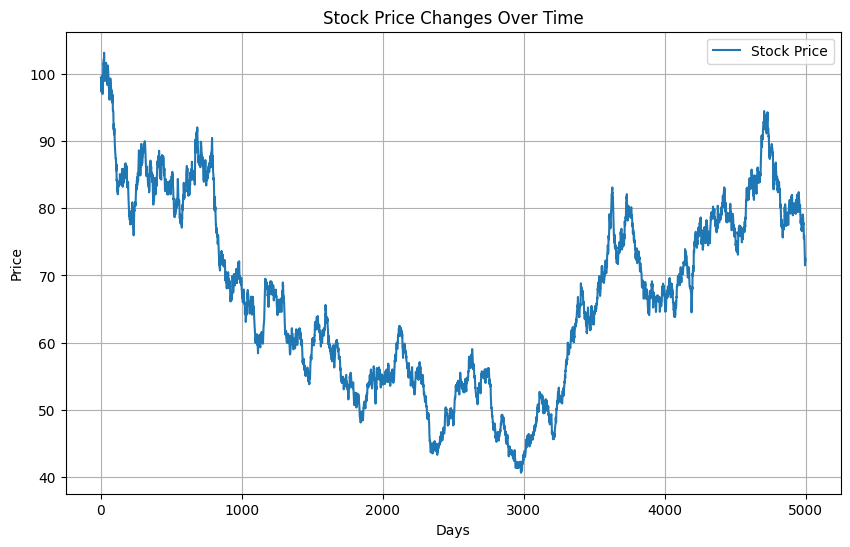

Skewness: 0.15897184741923734
Kurtosis: 0.11282709822071268


In [104]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import skewnorm, kurtosis, skew

def generate_skewed_kurtotic_returns(n_days, skewness, kurtosis_excess, mean_return, std_dev):
    """
    Generate random stock returns with specified skewness and kurtosis.

    Parameters:
    n_days (int): Number of days.
    skewness (float): Desired skewness.
    kurtosis_excess (float): Desired excess kurtosis (kurtosis - 3).
    mean_return (float): Mean of the returns.
    std_dev (float): Standard deviation of the returns.

    Returns:
    np.ndarray: Array of random returns.
    """
    # Generate random numbers from a skew-normal distribution
    a = skewness  # Skewness parameter
    returns = skewnorm.rvs(a, loc=mean_return, scale=std_dev, size=n_days)
    actual_skewness = skew(returns)
    print("Actual skewness:", actual_skewness)

    return returns
np.random.seed(42)  # For reproducibility
# Parameters
n_days = 5000  # Number of days
initial_price = 100  # Starting stock price
skewness = 1# Specify the skewness
kurtosis_excess = 00  # Specify the kurtosis (excess)
mean_return = -0.0056  # Mean daily return
std_dev = 0.01  # Standard deviation of daily returns

# Generate random returns with specified skewness and kurtosis
returns = generate_skewed_kurtotic_returns(n_days, skewness, kurtosis_excess, mean_return, std_dev)

# Calculate price changes
prices = initial_price * np.exp(np.cumsum(returns))

# Plot the price changes
plt.figure(figsize=(10, 6))
plt.plot(prices, label="Stock Price")
plt.title("Stock Price Changes Over Time")
plt.xlabel("Days")
plt.ylabel("Price")
plt.legend()
plt.grid()
plt.show()

# Verify skewness and kurtosis
print(f"Skewness: {skew(returns)}")
print(f"Kurtosis: {kurtosis(returns)}")

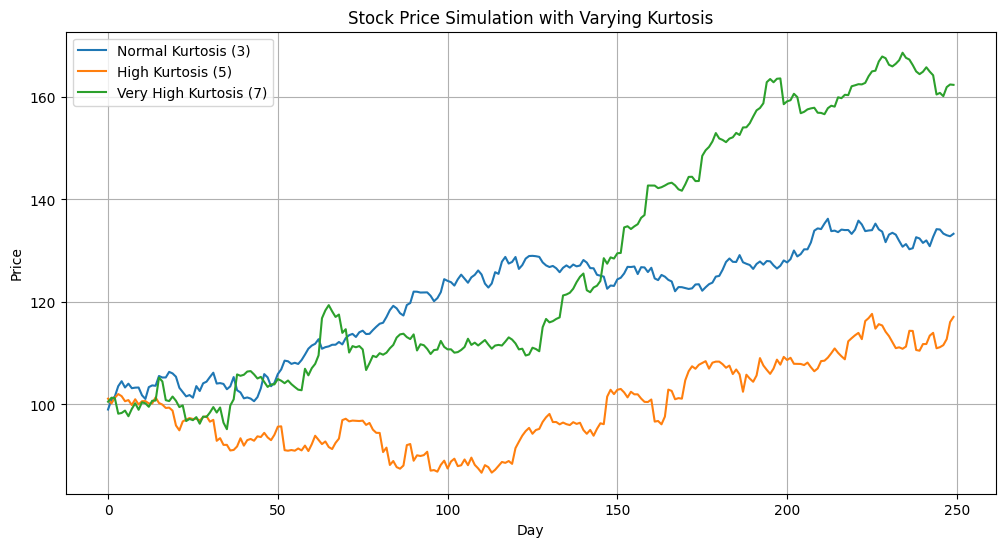

Kurtosis of Normal Returns: -0.3179496045456509
Kurtosis of High Kurtosis Returns: -0.3179496045456509


In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import kurtosis, norm

import matplotlib.pyplot as plt

def simulate_stock_price(n_days, mean_return, std_dev, kurtosis_level):
    """
    Simulates stock prices based on normal and kurtotic returns.

    Parameters:
    n_days (int): Number of simulation days.
    mean_return (float): Average daily return.
    std_dev (float): Standard deviation of daily returns.
    kurtosis_level (float):  kurtosis of the returns.

    Returns:
    pandas.DataFrame: DataFrame containing normal and kurtotic stock prices.
    """
    # Generate normal returns
    normal_returns = np.random.normal(mean_return, std_dev, n_days)
    # Adjust kurtosis by scaling extreme values
    if kurtosis_level > 3:
        # Calculate how many values to adjust (e.g., top/bottom 5%)
        num_adjust = int(n_days * 0.05)
        
        # Indices of largest and smallest returns
        largest_indices = normal_returns.argsort()[-num_adjust:][::-1]
        smallest_indices = normal_returns.argsort()[:num_adjust]
        
        # Scale these values to increase kurtosis
        scale_factor = np.sqrt(kurtosis_level - 3 + 1)  # Adjust scale based on desired kurtosis
        normal_returns[largest_indices] *= scale_factor
        normal_returns[smallest_indices] *= scale_factor
    
    # Calculate prices
    initial_price = 100
    normal_prices = initial_price * (1 + np.cumsum(normal_returns))
    
    # Create DataFrame
    df = pd.DataFrame({
        'Normal_Prices': normal_prices
    })
    
    return df

# Parameters
n_days = 250  # One year of trading days
mean_return = 0.001  # Average daily return
std_dev = 0.01  # Standard deviation of daily returns

# Simulate stock prices with different kurtosis levels
kurtosis_3 = simulate_stock_price(n_days, mean_return, std_dev, kurtosis_level=3)
kurtosis_5 = simulate_stock_price(n_days, mean_return, std_dev, kurtosis_level=5)
kurtosis_7 = simulate_stock_price(n_days, mean_return, std_dev, kurtosis_level=7)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(kurtosis_3['Normal_Prices'], label='Normal Kurtosis (3)')
plt.plot(kurtosis_5['Normal_Prices'], label='High Kurtosis (5)')
plt.plot(kurtosis_7['Normal_Prices'], label='Very High Kurtosis (7)')
plt.title('Stock Price Simulation with Varying Kurtosis')
plt.xlabel('Day')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


In [115]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import numpy as np

# Generate synthetic data
np.random.seed(42)
n_samples = 1000
data = {
    'feature1': np.random.randint(0, 10, n_samples),
    'feature2': np.random.randint(0, 10, n_samples),
    'feature3': np.random.randint(0, 10, n_samples),
    'target': np.random.choice(['A', 'B', 'C'], n_samples)
}
df = pd.DataFrame(data)

# Encode the target variable
label_encoder = LabelEncoder()
df['target'] = label_encoder.fit_transform(df['target'])
print("Encoded target variable:", df['target'].unique())
# Split data into training and testing sets
X = df[['feature1', 'feature2', 'feature3']]
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Feature selection using chi-square
chi2_selector = SelectKBest(chi2, k='all')
chi2_selector.fit(X_train, y_train)

# Get chi-square scores and p-values
chi2_scores = chi2_selector.scores_
p_values = chi2_selector.pvalues_

# Print feature importances
print("Chi-square scores:", chi2_scores)
print("P-values:", p_values)

# Train a RandomForest model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")


Encoded target variable: [0 1 2]
Chi-square scores: [1.381487   0.68214978 4.60062242]
P-values: [0.50120328 0.71100566 0.10022765]
Accuracy: 0.3233333333333333


In [135]:
import pandas as pd
from scipy.stats import chi2_contingency

# Create the contingency table
observed = pd.DataFrame({
    'Lung Cancer': [80000, 40000],
    'No Lung Cancer': [120000, 61000]
}, index=['Smoker', 'Non-Smoker'])

# Perform the Chi-Square test
chi2, p, dof, expected = chi2_contingency(observed)

# Print the results
print(f"Chi-Square Statistic: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of Freedom: {dof}")
print("Expected Frequencies Table:")
print(pd.DataFrame(expected, columns=observed.columns, index=observed.index))

# Interpret the results
alpha = 0.05
print("\nInterpretation:")
if p < alpha:
    print("Reject the null hypothesis: There is a significant association between smoking status and lung cancer.")
else:
    print("Fail to reject the null hypothesis: There is no significant association between smoking status and lung cancer.")

Chi-Square Statistic: 4.374210787441464
P-value: 0.03648672313595398
Degrees of Freedom: 1
Expected Frequencies Table:
             Lung Cancer  No Lung Cancer
Smoker      79734.219269   120265.780731
Non-Smoker  40265.780731    60734.219269

Interpretation:
Reject the null hypothesis: There is a significant association between smoking status and lung cancer.


In [140]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

# Generate synthetic data
np.random.seed(42)
n_samples = 10000
data = {
    'feature1': np.random.randn(n_samples),
    'feature2': np.random.randn(n_samples),
}
df = pd.DataFrame(data)
df['target'] = 1 + 0.02 * df['feature1'] + 0.3 * df['feature2'] + np.random.randn(n_samples) * 0.5  # Linear relationship with noise    
# Prepare the data
X = df[['feature1', 'feature2']]  # Features
y = df['target']  # Target variable

# Add a constant to the features (for the intercept term)
X = sm.add_constant(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Fit the linear regression model
model = sm.OLS(y_train, X_train).fit()

# Print the model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.291
Model:                            OLS   Adj. R-squared:                  0.291
Method:                 Least Squares   F-statistic:                     1436.
Date:                Sun, 25 May 2025   Prob (F-statistic):               0.00
Time:                        12:26:05   Log-Likelihood:                -4962.3
No. Observations:                7000   AIC:                             9931.
Df Residuals:                    6997   BIC:                             9951.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9999      0.006    170.133      0.0